Purpose of this module is to import raw wiki_nlp data, clean up, build a linear regression model and visualize.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import ResidualsPlot

In [2]:
# import wiki_nlp and clean
wiki_nlp = pd.read_csv('wiki_nlp.csv')
wiki_nlp = wiki_nlp.rename(columns={'this_article_unique_name': 'article_name'}) # Just in case there's a word named 'article_name' in NLP set
wiki_nlp.set_index('article_name', inplace=True) #set article name as index
wiki_nlp.fillna(value = 0, inplace=True)
wiki_nlp = wiki_nlp.reset_index()
wiki_nlp.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

In [3]:
wiki_nlp.head()

,article_name,aurelio,padovani,february,june,fascist,war,mussolini,naples,fascism,...,rosson,jorasanko,taltala,calcutta,kmc,bahrenborstel,diepholz,redmond,biologist,obe
0,Aurelio Padovani,6.0,18.0,3.0,3.0,7.0,3.0,9.0,7.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Skedala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Mandera Central Constituency,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Syunya Mori,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gonzen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The above dataframe does not have the target (number of languages). Import target (num of lang) from the TenFeature model

In [4]:
wiki_feat = pd.read_csv('../TenFeatures/wiki_10feat.csv')
wiki_lang = wiki_feat[['article_name','languages']]
wiki_lang = wiki_lang.rename(columns={'languages': 'lang_total_num_target'})

# join two dataframes
wiki_nlp_comb = wiki_lang.merge(wiki_nlp, left_on='article_name', right_on='article_name')
wiki_nlp_comb = wiki_nlp_comb.reset_index()
wiki_nlp_comb.set_index('article_name', inplace=True) #set article name as index

The resulting dataframe is way too large. We will remove the words that have (cumulatively) very few entries. (the next three cells)

In [5]:
# remove columns that have less than 300 entries all rows combined
column_totals = wiki_nlp_comb.sum(axis = 0).sort_values(ascending=False)
print(len(column_totals))
print(column_totals.where(column_totals > 300).count())
frequent_words = column_totals.where(column_totals > 300)
frequent_words = frequent_words.dropna() # list of columns with counts > 300

31302
494


In [6]:
frequent_words_list = list(frequent_words.index)
df_columns = wiki_nlp_comb.columns
columns_to_be_dropped = []
for column in df_columns:
    if column not in frequent_words_list:
        columns_to_be_dropped.append(column)

In [7]:
wiki_nlp_comb.drop(columns = columns_to_be_dropped, inplace=True, errors='ignore')

In [8]:
#normalize all features except languages

normalized_wiki_nlp = (wiki_nlp_comb - wiki_nlp_comb.mean()) / wiki_nlp_comb.std()
normalized_wiki_nlp['lang_total_num_target'] = wiki_nlp_comb['lang_total_num_target']
normalized_wiki_nlp.drop(columns=['level_0'], inplace=True, errors='ignore')

In [9]:
normalized_wiki_nlp.sort_values(by='lang_total_num_target',ascending=False).head(10)

,lang_total_num_target,february,june,war,party,retrieved,december,italy,isbn,county,...,dam,shrew,castle,paok,over,evangelical,tornado,mpc,jpl,socorro
article_name,,,,,,,,,,,,,,,,,,,,,
1858,166,1.164171,3.970916,0.966774,-0.096364,0.067637,1.876650,-0.048313,0.777887,-0.164291,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
Ice,133,0.883530,1.351314,-0.102815,-0.096364,2.274145,1.169877,-0.048313,3.429006,-0.164291,...,0.663601,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
Dysprosium,123,-0.098714,0.478113,-0.102815,-0.096364,0.921769,0.321748,-0.048313,2.324373,-0.164291,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
Eucalyptus,91,0.322248,-0.176788,-0.102815,-0.096364,2.914744,-0.102316,-0.048313,1.440667,-0.164291,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
.uy,86,-0.098714,-0.176788,0.538939,-0.096364,-0.288251,-0.102316,-0.048313,-0.105819,-0.164291,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
Lubusz Voivodeship,75,-0.098714,-0.176788,-0.102815,-0.096364,-0.074718,-0.102316,-0.048313,-0.105819,8.002188,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
Jeans,73,0.743209,0.696413,-0.102815,-0.096364,1.704724,-0.102316,2.191330,0.556961,-0.164291,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
Gamete,69,-0.098714,-0.176788,-0.102815,-0.096364,-0.003540,-0.102316,-0.048313,-0.105819,-0.164291,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577
Temple in Jerusalem,66,-0.098714,0.696413,0.752856,-0.096364,0.494703,-0.102316,-0.048313,1.440667,-0.164291,...,-0.021383,-0.023592,-0.036402,-0.016833,-0.019057,-0.023489,-0.019744,-0.016577,-0.016577,-0.016577


In [11]:
normalized_wiki_nlp.dropna(axis='columns',inplace=True)
normalized_wiki_nlp.shape

(3633, 482)

Will be modeling below with LinearRegression with LassoCV.

In [10]:
X = normalized_wiki_nlp.loc[:, 'february':'socorro']
y = normalized_wiki_nlp['lang_total_num_target']

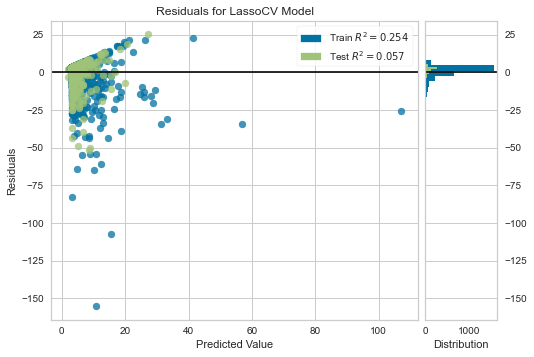

0.5064105538156097

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
model = LassoCV()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [30]:
# list of words that have the highest-impact coefficients
coefs_list = list(zip(X.columns, visualizer.coef_))
coefs_df = pd.DataFrame(coefs_list, columns =['column_name', 'coef']) 
coefs_df.sort_values(by='coef',ascending=False)

,column_name,coef
332,population,1.212857
8,county,0.814047
211,roman,0.779921
26,also,0.703669
83,le,0.666219
...,...,...
55,united,-0.249402
349,well,-0.271809
425,show,-0.279516
291,date,-0.377511


Export dataframe to be used in the combined model later

In [76]:
normalized_wiki_nlp.to_csv(r'wiki_nlp_small.csv')